In [365]:
#imports
import sys
import cellrank as cr
import scanpy as sc
import warnings
import numpy as np
from cellrank.kernels import RealTimeKernel
from moscot.problems.time import TemporalProblem
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams

In [366]:
#settings
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2
warnings.simplefilter("ignore", category=UserWarning)

In [367]:
#data
adata = sc.read_h5ad("aa_aligned_adata_sc.h5ad")

In [368]:
## Experimental Time

In [369]:
# preprocess
adata.obs["timepoint_cf"] = None

for i, r in adata.obs.iterrows():
    if r["timepoint"] == "pre":
        adata.obs.at[i, "timepoint_cf"] = 0
    if r["timepoint"] == "post":
        adata.obs.at[i, "timepoint_cf"] = 1
        
sc.pp.pca(adata)
sc.pp.neighbors(adata, random_state=0)

In [370]:
#adata = adata[adata.obs["fine_clustering"].isin(['CD4_Tcm', 'CD4_Tem', 'CD4_Tnaive', 'CD4_Treg', 'CD4_Th2'])]
adata = adata[adata.obs["fine_clustering"].isin(['CD4_Tcm', 'CD4_Tnaive', 'CD4_Treg', 'CD4_Tem'])]

In [371]:
#adata = adata[adata.obs["treatment"].isin(["Saline"])]
#adata = adata[adata.obs["treatment"].isin(["1.5MIU"])]
adata = adata[adata.obs["treatment"].isin(["2.5MIU"])]
#adata = adata[adata.obs["treatment"].isin(["1.5MIU", "2.5MIU"])]

In [372]:
tp = TemporalProblem(adata)

tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)

In [373]:
adata.obs["timepoint_cf"] = adata.obs["timepoint_cf"].astype(float)
tp = tp.prepare(time_key="timepoint_cf")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


In [374]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(4665, 5619)].                                  


In [375]:
adata.obs["timepoint_cf"] = adata.obs["timepoint_cf"].astype("category")
tmk = RealTimeKernel.from_moscot(tp)

In [376]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

100%|██████████| 1/1 [00:00<00:00, 15141.89time pair/s]

Using automatic `threshold=2.732895515531861e-26`


RealTimeKernel[n=10284, threshold='auto', self_transitions='all']

Simulating `100` random walks of maximum length `500`


100%|██████████| 100/100 [00:07<00:00, 12.94sim/s]

    Finish (0:00:07)
Plotting random walks


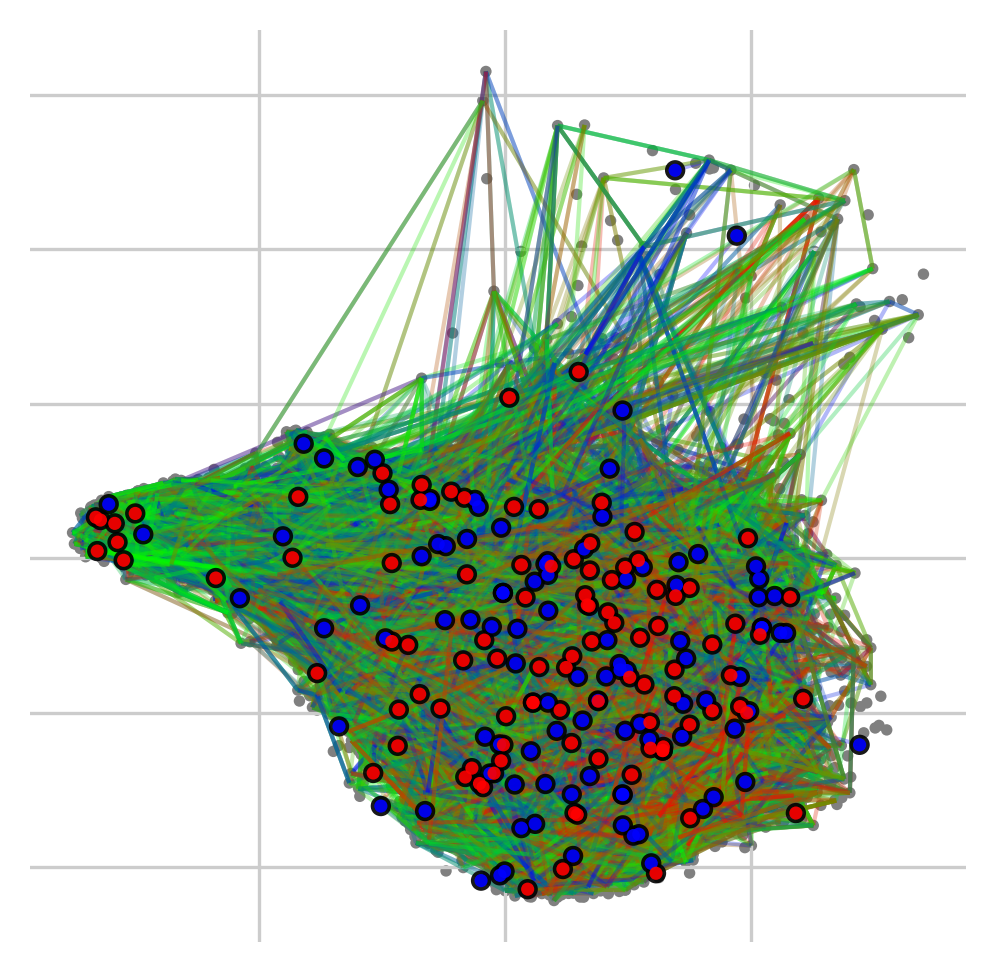

In [377]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)] # Blue, Green, Red
n_bins = 100 # Discretizes the interpolation into bins
cmap_name = 'my_custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

tmk.plot_random_walks(
    max_iter=500,
    start_ixs={"timepoint_cf": 0.0},
    basis="X_umap",
    seed=0,
    dpi=150,
    size=30,
    cmap=custom_cmap
)

In [378]:
adata.uns["fine_clustering_colors"] = ["#5AB67E", "#E55C5C", "#B65BCD", "#74A1C6"]

Computing flow from `CD4_Treg` into `3` cluster(s) in `1` time points
Plotting flow from `CD4_Treg` into `2` cluster(s) in `1` time points


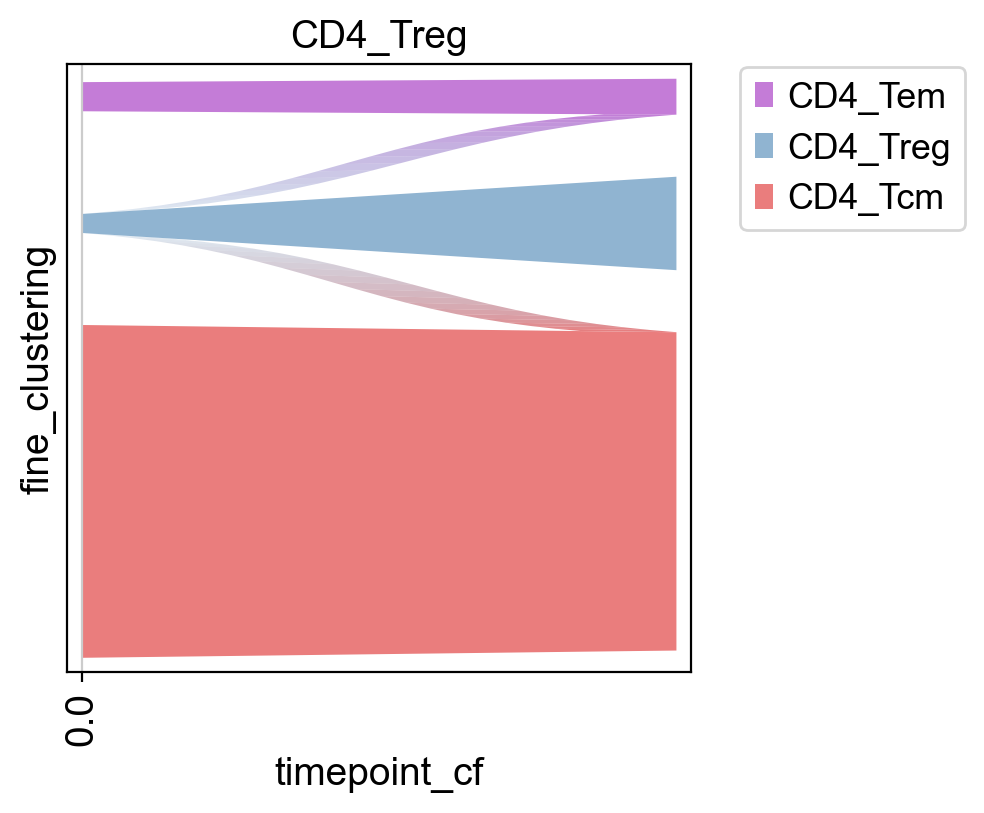

In [379]:
ax = tmk.plot_single_flow(
    cluster_key="fine_clustering",
    time_key="timepoint_cf",
    cluster="CD4_Treg",
    min_flow=0.05,
    xticks_step_size=4,
    show=False
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [380]:
## Pseudo Time

In [381]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['fine_clustering'].isin(['CD4_Tcm', 'CD4_Tem', 'CD4_Tnaive', 'CD4_Th2']))[0]

In [382]:
sc.tl.diffmap(adata)
sc.tl.dpt(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

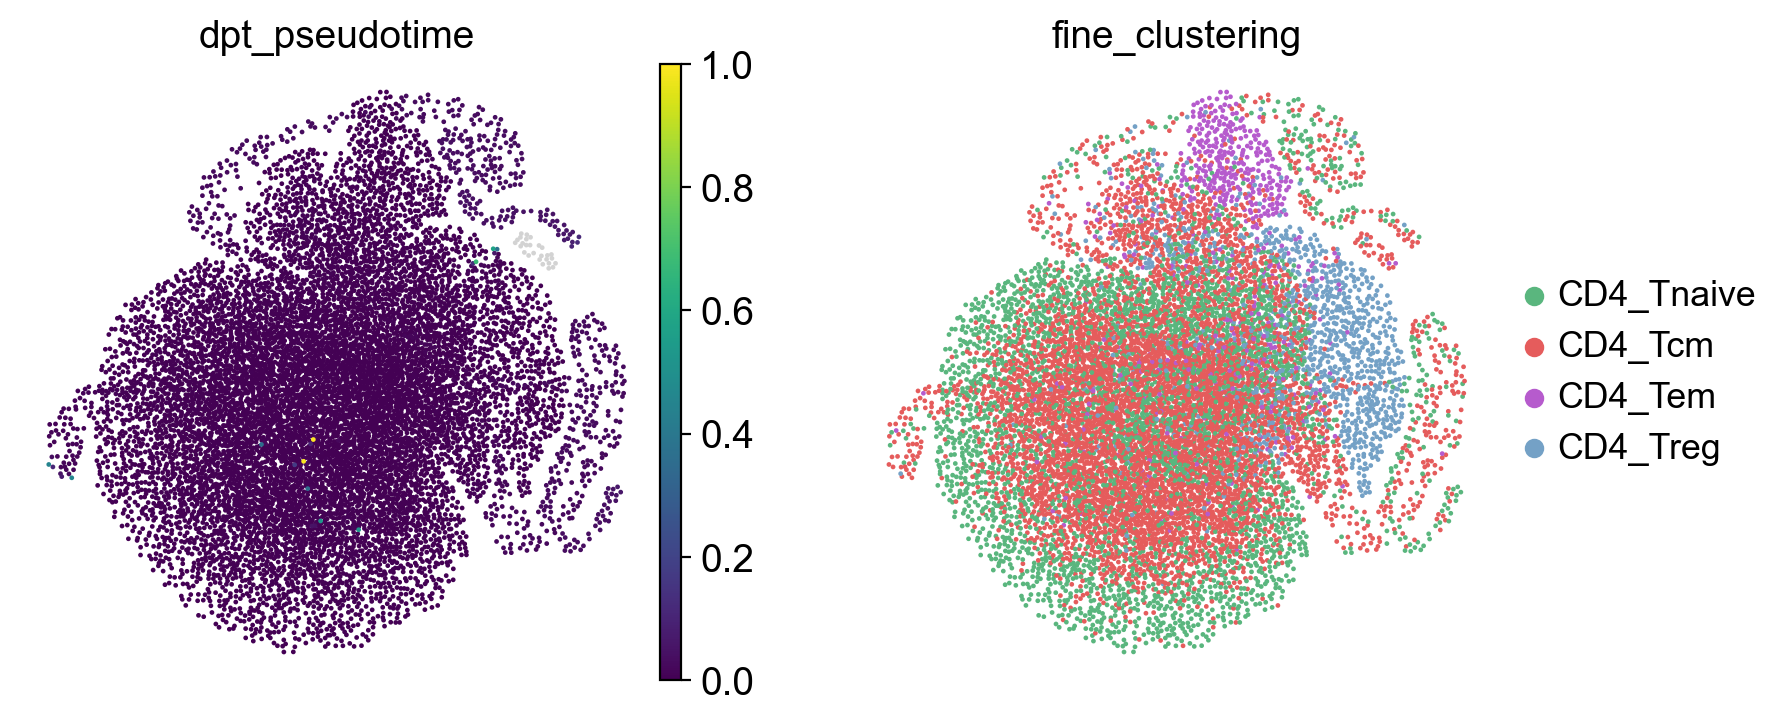

In [383]:
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color=['dpt_pseudotime', 'fine_clustering'])

In [384]:
## carotids

In [385]:
carotids = sc.read_h5ad("/Users/caseag/Desktop/Mallat Lab/ELLIPSE/parse_run_25_mar_2024/combined_fine_clustering_9_apr_2024.h5ad")

In [386]:
carotids.obs["initial_clustering"].unique()

['T/NK Cells', 'pDCs', 'Tregs', 'B Cells', 'Macro/Mono', 'Mast Cells', 'SMC', 'Plasmablasts']
Categories (8, object): ['B Cells', 'Macro/Mono', 'Mast Cells', 'Plasmablasts', 'SMC', 'T/NK Cells', 'Tregs', 'pDCs']

In [387]:
carotids.obs["fine_clustering"].unique()

['CD8+ Tem', 'CD16+ NK', 'Tregs', 'CD4+ Tcm/naive', 'CD8+ Temra', ..., 'TREM1+ Macrophages', 'TREM2+ Macrophages', 'Proliferating T Cells', 'C1Q+ Macrophages', 'SMCs']
Length: 21
Categories (21, object): ['B Cells', 'C1Q+ Macrophages', 'CD4+ Tcm/naive', 'CD4+ Teff', ..., 'Tregs', 'cDC1', 'cDC2', 'pDCs']

In [388]:
carotids_ctrl = carotids[carotids.obs["treatment"] == "IL-2"]
#carotids_ctrl = carotids
carotids_ctrl = carotids_ctrl[carotids_ctrl.obs["initial_clustering"].isin(["T/NK Cells", "Tregs"])]
carotids_ctrl = carotids_ctrl[~carotids_ctrl.obs["fine_clustering"].isin(["CD16+ NK", "CD16- NK"])]

In [389]:
carotids_ctrl.uns['iroot'] = np.flatnonzero(carotids_ctrl.obs['fine_clustering'].isin(['CD4+ Teff']))[0]

In [390]:
sc.tl.diffmap(carotids_ctrl)
sc.tl.dpt(carotids_ctrl)
sc.pp.neighbors(carotids_ctrl, n_neighbors=10, use_rep='X_diffmap')

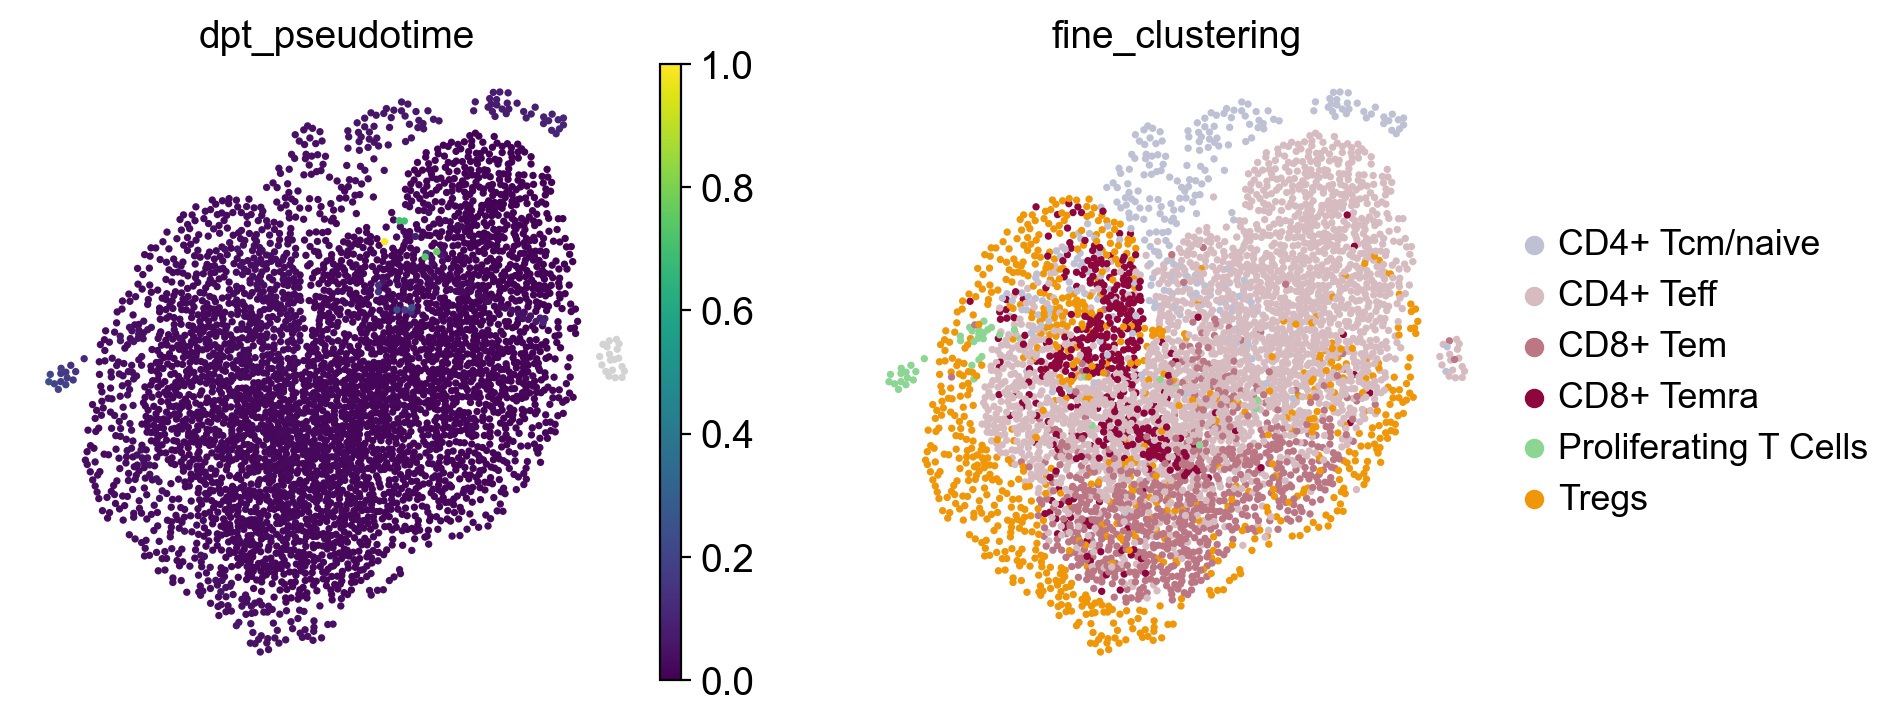

In [391]:
sc.tl.draw_graph(carotids_ctrl)
sc.pl.draw_graph(carotids_ctrl, color=['dpt_pseudotime', 'fine_clustering'])